<a href="https://colab.research.google.com/github/Dikshant0000/71_DAV1/blob/main/exp4%2C5%2C6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'air-passengers:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1057%2F1913%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240402%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240402T180139Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc84e28a675417f547898655f1b66af82c54e6d70c41cac0fda50f31489e3552b108c55ddca4c8f7afacb7823485e94a612ce886e41a441a8f4634d3ed5f8f2a4d4872a8d2ab64408346512b5fe0979cf22a169fbf54f709a422c5118b5e783aebbb4c41b6b8a80f3909d1bcc27d820b1f0f59766084413e8b5443e040fe4763b380dc84fb0509e2ca5a2e0fef6f2aa2c081885f424651ab6bb6bfbb569c4fe20387fe1ee9a89409c870808e5791f2ae14bb8f34e29aa59dfc00b20c803821194b0bb17551a1e76704adef5593f0d47280e951dd1354fef9bf4a16f47bcea80f76593a7ebeeb3737c65c022528fa10ccd8b1041b8b49eddebbc216336cf445491'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 764 bytes downloaded
Downloaded and uncompressed: air-passengers
Data source import complete.


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/air-passengers/AirPassengers.csv


In [4]:
! pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.1 MB/s eta 0:00:00


In [5]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from scipy.special import boxcox, inv_boxcox
from scipy import stats
from pmdarima import auto_arima

plt.rcParams['figure.figsize']=(17,5)
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")

In [6]:
def ADF(data):
    result = adfuller(data)
    print(f'ADF Statistic: {result[0]}')
    print(f'n_lags: {result[2]}')
    print(f'p-value: {result[1]:.20f}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')

# -------------------------------------------------------------
def ACF_and_PACF(data):
    fig = plt.figure(figsize=(17,10))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(data, lags=30, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(data, lags=30, ax=ax2)

Data Understanding

In [7]:
df= pd.read_csv("/kaggle/input/air-passengers/AirPassengers.csv", parse_dates=["Month"])
df.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [8]:
df['Month'] = pd.to_datetime(df['Month'],format="%Y-%m")
df = df.set_index('Month')
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [9]:
df.shape

(144, 1)

Preprocessing


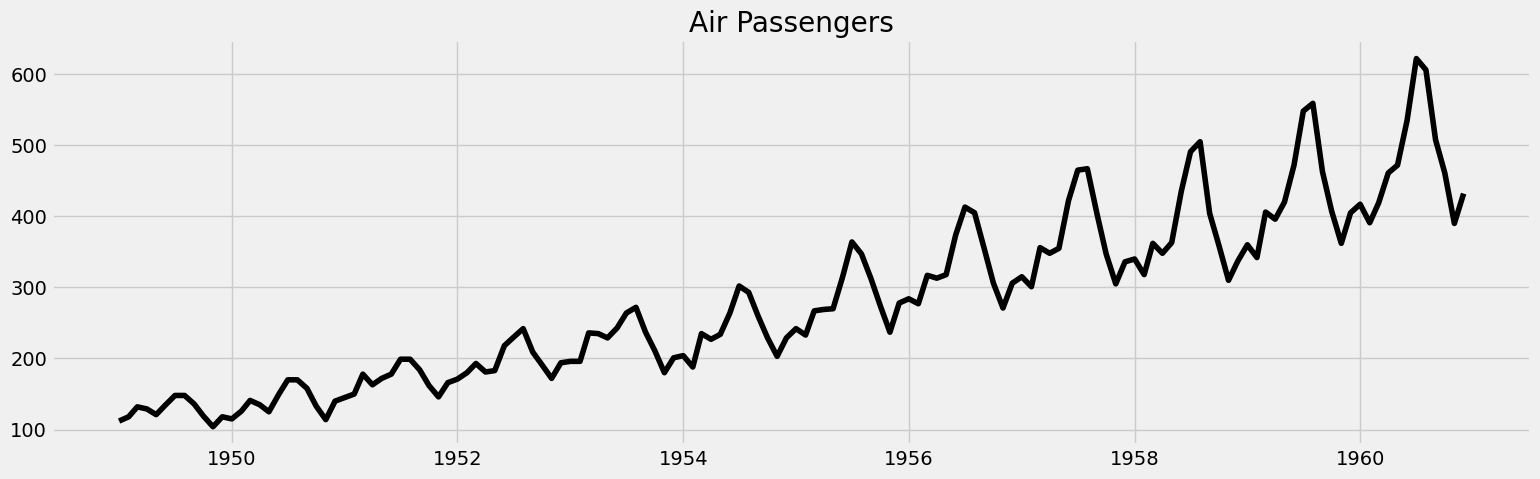

In [10]:
plt.plot(df,color='black')
plt.title("Air Passengers")
plt.show()

<Axes: ylabel='#Passengers'>

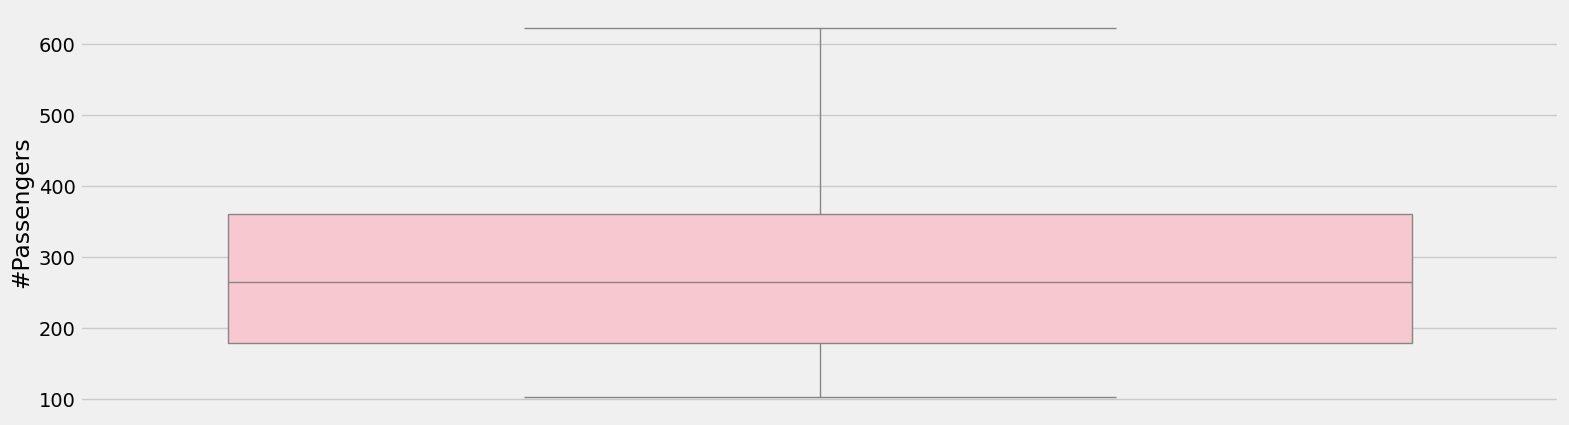

In [11]:
sns.boxplot(df['#Passengers'], color='pink')

<Axes: xlabel='#Passengers', ylabel='Density'>

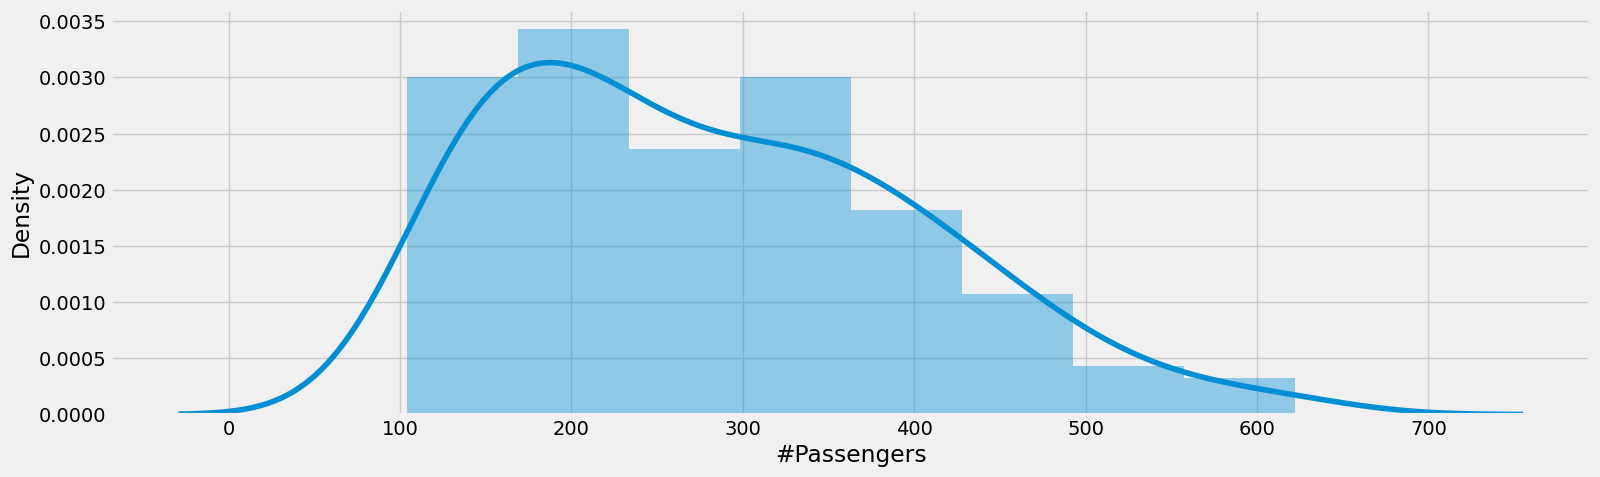

In [12]:
sns.distplot(df['#Passengers'])

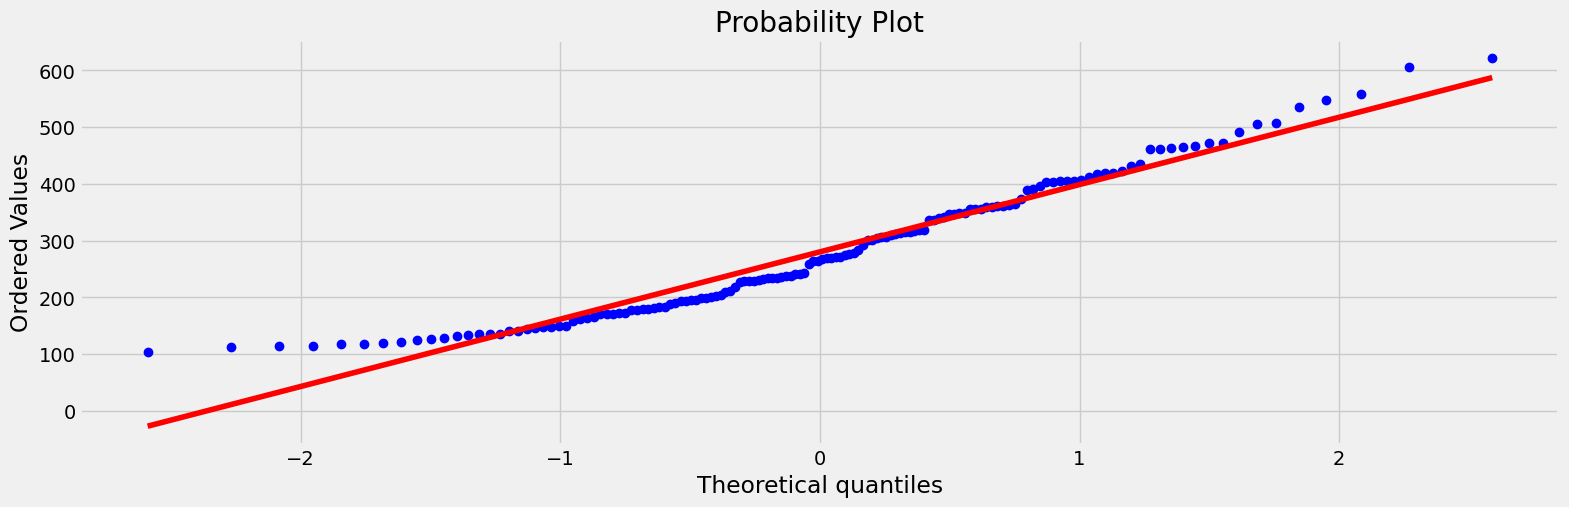

In [13]:
stats.probplot(df['#Passengers'],plot=pylab)
pylab.show()

In [14]:
length_train = math.floor(len(df["#Passengers"])*0.8)

train = df[:length_train]
test = df[length_train:]

Decomposition

--------------------------------------------------
                     additive
-------------------------------------------------- 



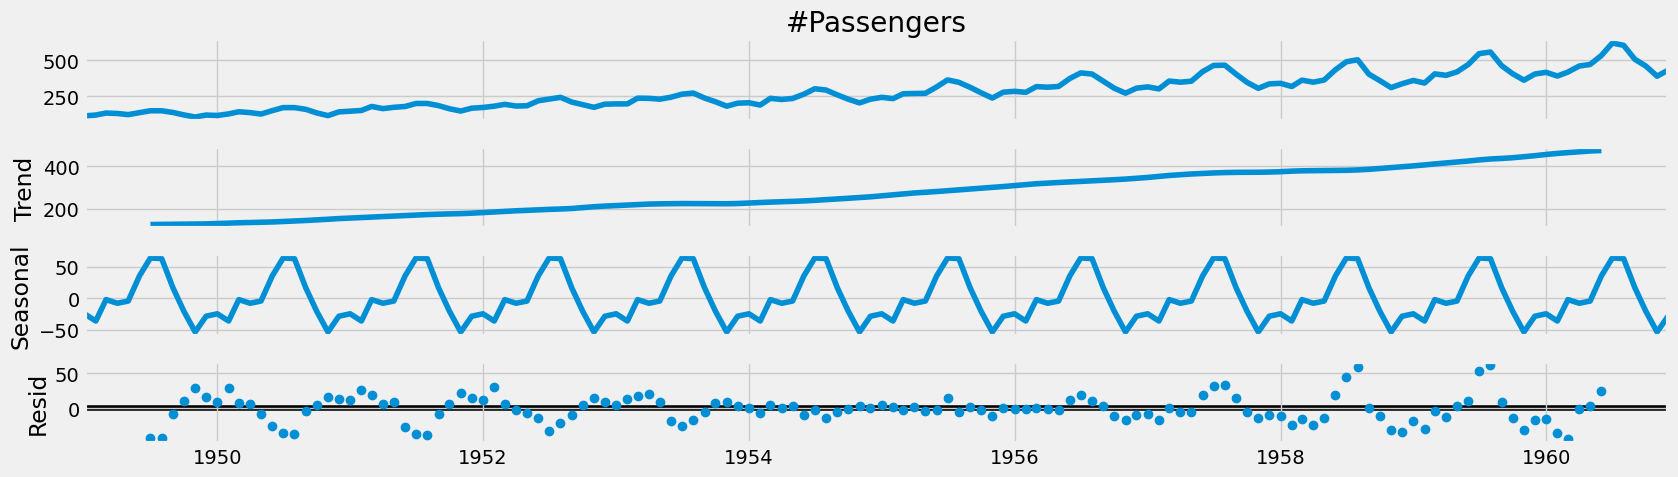



 --------------------------------------------------
                     multiplicative
-------------------------------------------------- 



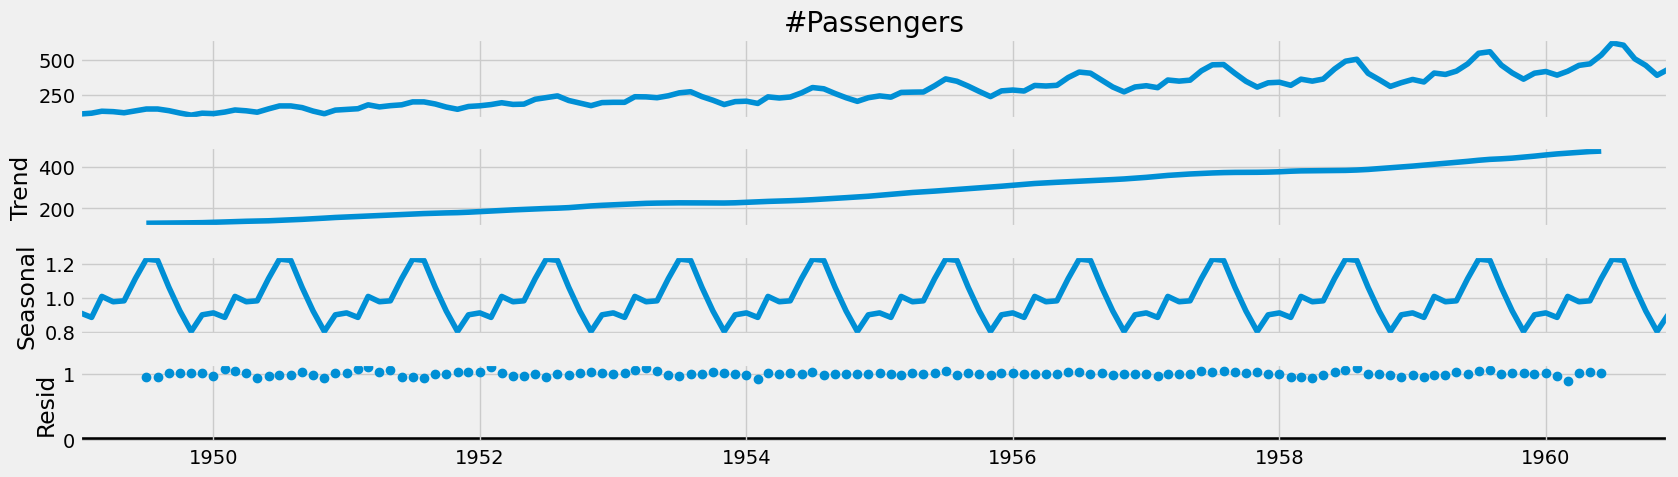

In [15]:
print('-'*50)
print(' '*20,'additive')
print('-'*50,'\n')

decomposition = sm.tsa.seasonal_decompose(df['#Passengers'], model='additive')
decomposition.plot()
plt.show()

#----------------------------------------------------
print('\n\n','-'*50)
print(' '*20,'multiplicative')
print('-'*50,'\n')

decomposition = sm.tsa.seasonal_decompose(df['#Passengers'], model='multiplicative')
fig = decomposition.plot()
plt.show()

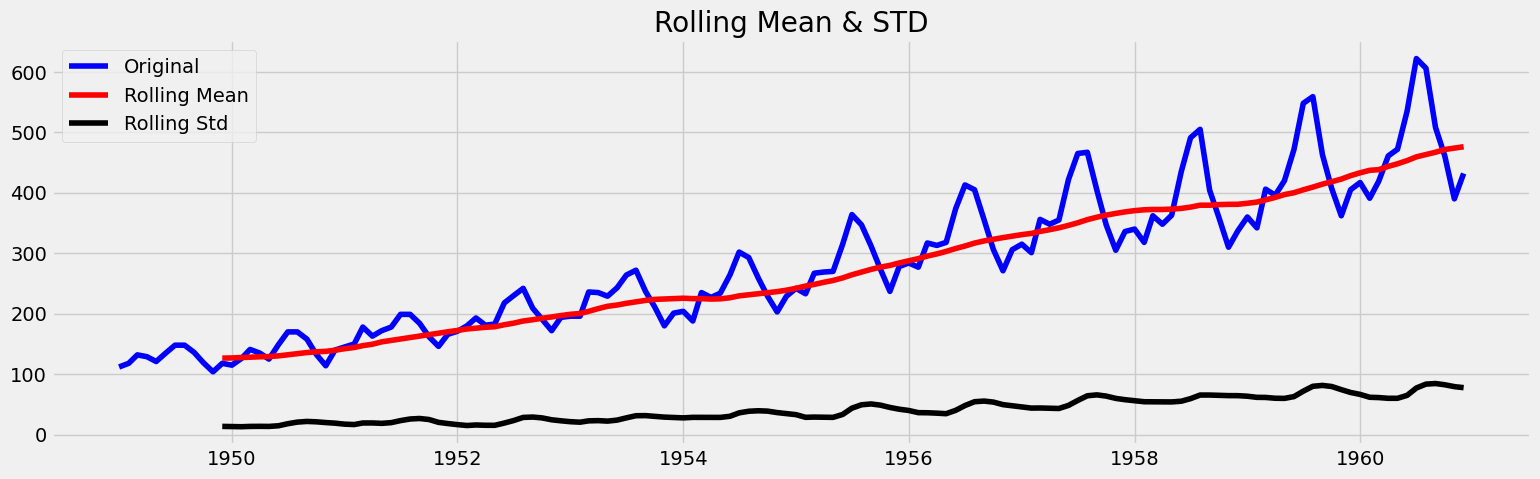

In [16]:
rolmean = df.rolling(window=12).mean()
rolstd = df.rolling(window=12).std()
orig = plt.plot(df, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')

plt.legend(loc='best')
plt.title('Rolling Mean & STD')
plt.show()

In [18]:
ADF(df['#Passengers'])

ADF Statistic: 0.8153688792060498
n_lags: 13
p-value: 0.99188024343764102930
Critial Values:
   1%, -3.4816817173418295
Critial Values:
   5%, -2.8840418343195267
Critial Values:
   10%, -2.578770059171598


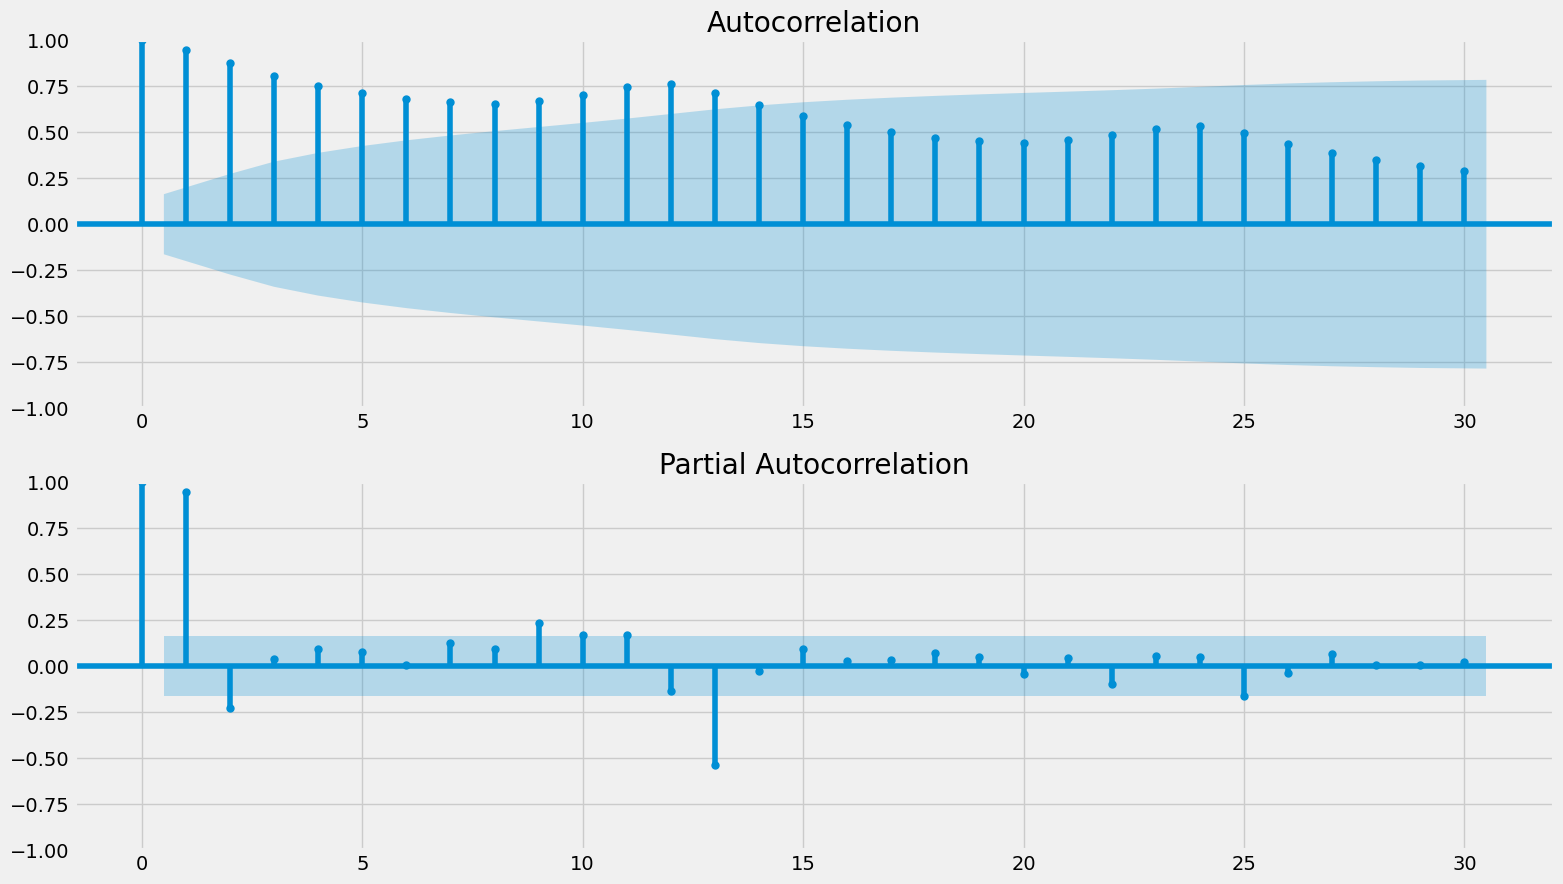

In [19]:
ACF_and_PACF(df['#Passengers'])

Elimination non-constant variance with boxcox

--------------------------------------------------
      fitted_lambda is:  0.14802265137037945
-------------------------------------------------- 



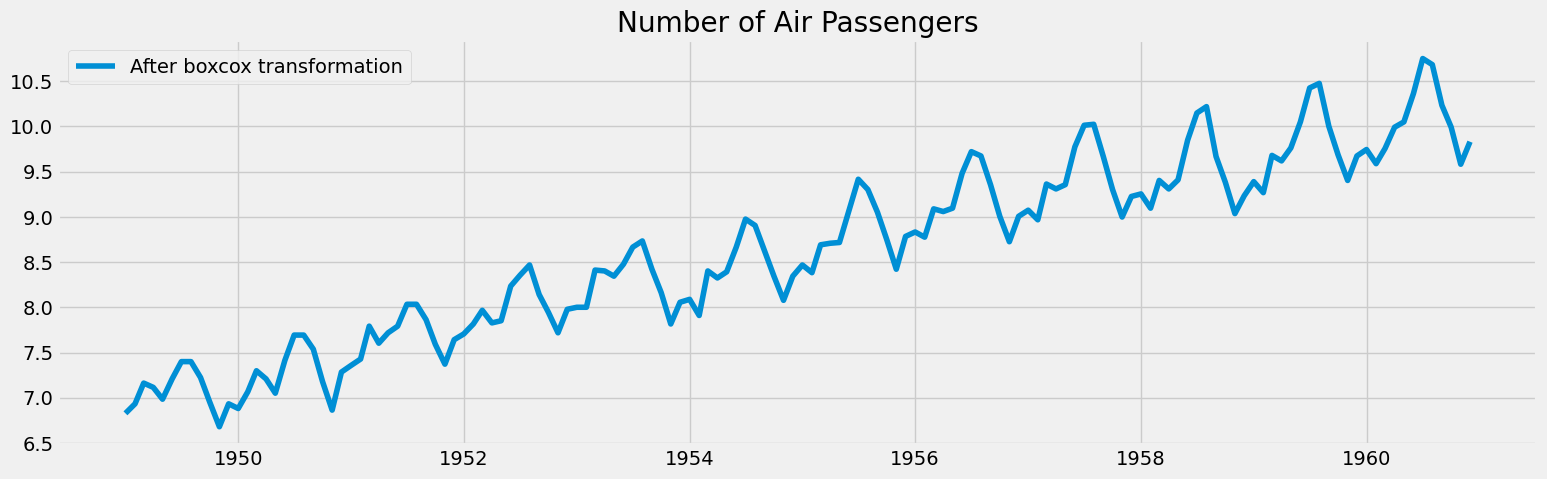

In [20]:
fitted_data, fitted_lambda = stats.boxcox(df['#Passengers'])
print('-'*50)
print(' '*5,'fitted_lambda is: ',fitted_lambda)
print('-'*50,'\n')

data_boxcox = pd.Series(boxcox(df['#Passengers'],fitted_lambda),index=df.index)
plt.plot(data_boxcox, label="After boxcox transformation")
plt.legend()
plt.title("Number of Air Passengers")
plt.show()

In [21]:
ADF(data_boxcox)

ADF Statistic: -1.3260708968567534
n_lags: 13
p-value: 0.61716206570036902246
Critial Values:
   1%, -3.4816817173418295
Critial Values:
   5%, -2.8840418343195267
Critial Values:
   10%, -2.578770059171598


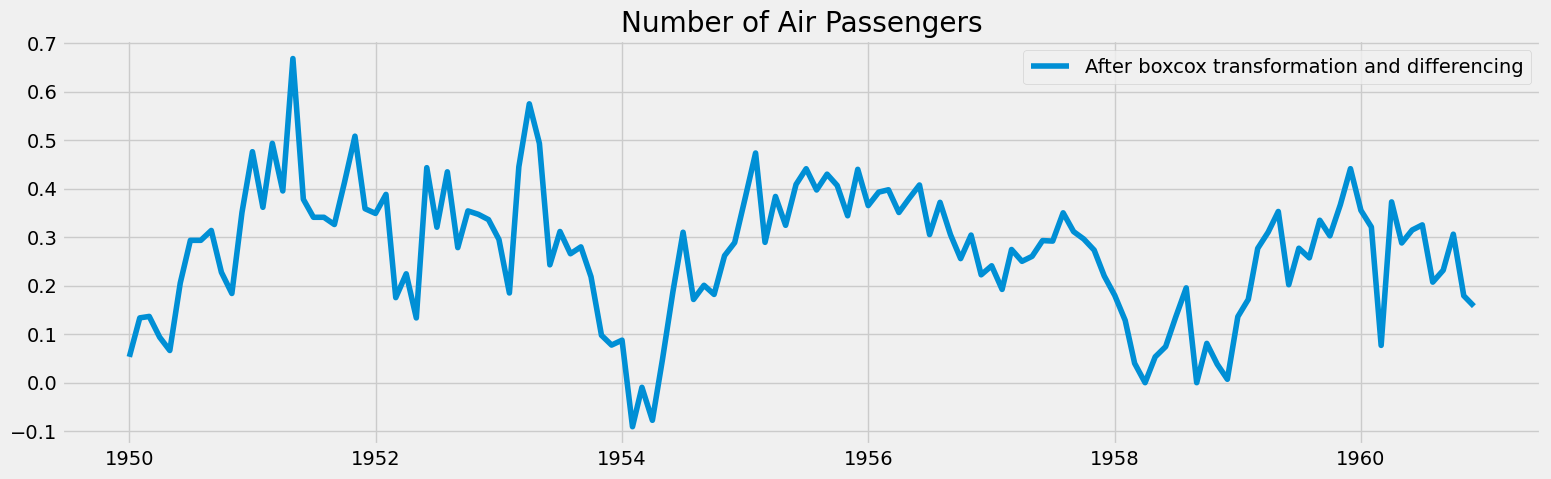

In [22]:
data_boxcox_diff_12= pd.Series(data_boxcox - data_boxcox.shift(periods=12), index=df.index)
data_boxcox_diff_12.dropna(inplace=True)

plt.plot(data_boxcox_diff_12, label="After boxcox transformation and differencing")
plt.legend()
plt.title("Number of Air Passengers")
plt.show()

In [23]:
ADF(data_boxcox_diff_12)

ADF Statistic: -2.8421134584100276
n_lags: 12
p-value: 0.05250539863856155953
Critial Values:
   1%, -3.4865346059036564
Critial Values:
   5%, -2.8861509858476264
Critial Values:
   10%, -2.579896092790057


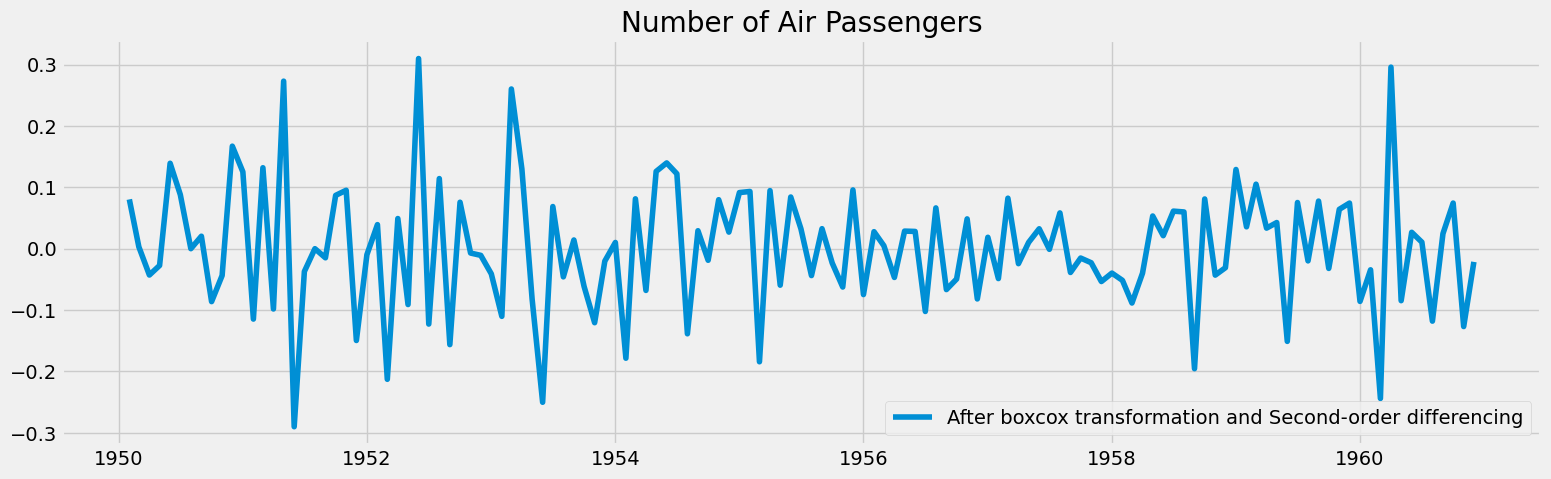

In [24]:
data_boxcox_second_order_diff= pd.Series(data_boxcox_diff_12 - data_boxcox_diff_12.shift(), index=df.index)
data_boxcox_second_order_diff.dropna(inplace=True)

plt.plot(data_boxcox_second_order_diff, label="After boxcox transformation and Second-order differencing")
plt.legend()
plt.title("Number of Air Passengers")
plt.show()

In [25]:
ADF(data_boxcox_second_order_diff)

ADF Statistic: -4.393872588707454
n_lags: 12
p-value: 0.00030433262632178592
Critial Values:
   1%, -3.4870216863700767
Critial Values:
   5%, -2.8863625166643136
Critial Values:
   10%, -2.580009026141913


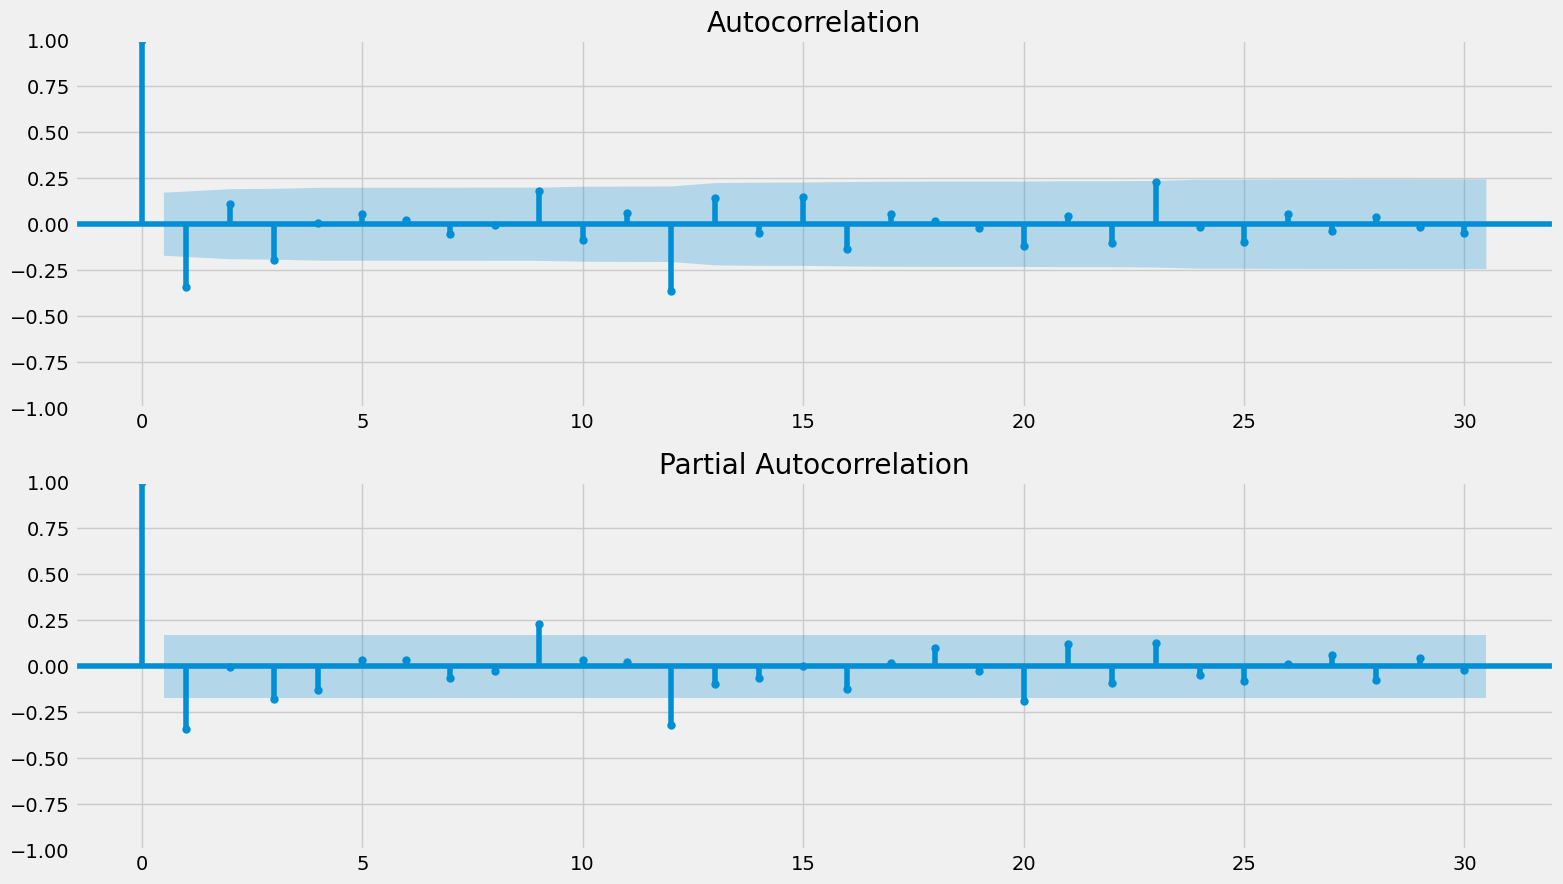

In [26]:
ACF_and_PACF(data_boxcox_second_order_diff)

Modellling

In [27]:
train_boxcox_second_order_diff = data_boxcox_second_order_diff[:length_train]
test_boxcox_second_order_diff = data_boxcox_second_order_diff[length_train:]

In [28]:
train_boxcox_second_order_diff.tail()

Month
1959-04-01    0.033505
1959-05-01    0.042581
1959-06-01   -0.150944
1959-07-01    0.075219
1959-08-01   -0.019876
Name: #Passengers, dtype: float64

In [29]:
test_boxcox_second_order_diff.head()

Month
1959-09-01    0.077554
1959-10-01   -0.032159
1959-11-01    0.064099
1959-12-01    0.074289
1960-01-01   -0.085853
Name: #Passengers, dtype: float64

AR

In [30]:
model_ar = ARIMA(train_boxcox_second_order_diff, order=(12,0,0))
model_fit_ar = model_ar.fit()
model_fit_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  115
Model:                ARIMA(12, 0, 0)   Log Likelihood                 121.997
Date:                Tue, 02 Apr 2024   AIC                           -215.994
Time:                        18:22:10   BIC                           -177.565
Sample:                    02-01-1950   HQIC                          -200.396
                         - 08-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.005      0.183      0.855      -0.009       0.011
ar.L1         -0.3218      0.084     -3.815      0.000      -0.487      -0.156
ar.L2         -0.0157      0.110     -0.144      0.886      -0.231       0.199
ar.L3         -0.1334      0.107     -1.244      0.214      -0.344       0.077
ar.L4         -0.0969      0.116     -0.834      0.404      -0.324       0.131
ar.L5          0.0099      0.087      0.114      0.909      -0.160       0.180
ar.L6          0.0587      0.094      0.628      0.530      -0.125       0.242
ar.L7         -0.0452      0.107     -0.423      0.672      -0.255       0.164
ar.L8         -0.0028      0.093     -0.030      0.976      -0.186       0.180
ar.L9          0.1305      0.094      1.383      0.167      -0.054       0.315
ar.L10         0.0242      0.099      0.245      0.807      -0.170       0.218
ar.L11        -0.1132      0.096     -1.176      0.240      -0.302       0.076
ar.L12        -0.3798      0.090     -4.210      0.000      -0.557      -0.203
sigma2         0.0069      0.001      6.894      0.000       0.005       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 1.33
Prob(Q):                              0.71   Prob(JB):                         0.51
Heteroskedasticity (H):               0.54   Skew:                             0.26
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Tranformation

In [31]:
predictions_AR_diff = pd.Series(model_fit_ar.fittedvalues, copy=True)
print(predictions_AR_diff.head())

Month
1950-02-01    0.000934
1950-03-01   -0.024041
1950-04-01    0.001496
1950-05-01   -0.000406
1950-06-01    0.003956
dtype: float64


In [32]:
predictions_AR_diff_cumsum = predictions_AR_diff.cumsum()
print(predictions_AR_diff_cumsum)

Month
1950-02-01    0.000934
1950-03-01   -0.023107
1950-04-01   -0.021612
1950-05-01   -0.022018
1950-06-01   -0.018062
                ...   
1959-04-01    0.136133
1959-05-01    0.088933
1959-06-01    0.021164
1959-07-01    0.041440
1959-08-01    0.005586
Length: 115, dtype: float64


In [33]:
predictions_AR_boxcox = pd.Series(data_boxcox, index=data_boxcox.index)
predictions_AR_boxcox

Month
1949-01-01     6.827490
1949-02-01     6.932822
1949-03-01     7.161892
1949-04-01     7.114611
1949-05-01     6.983787
                ...    
1960-08-01    10.684049
1960-09-01    10.234573
1960-10-01     9.992159
1960-11-01     9.582623
1960-12-01     9.831860
Name: #Passengers, Length: 144, dtype: float64

In [34]:
predictions_AR_boxcox = pd.Series(data_boxcox, index=data_boxcox.index)
predictions_AR_boxcox = predictions_AR_boxcox.add(predictions_AR_diff_cumsum, fill_value=0)
predictions_AR_boxcox.head()

Month
1949-01-01    6.827490
1949-02-01    6.932822
1949-03-01    7.161892
1949-04-01    7.114611
1949-05-01    6.983787
dtype: float64

In [35]:
predictions_AR = inv_boxcox(predictions_AR_boxcox, fitted_lambda)
predictions_AR.head()

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
dtype: float64

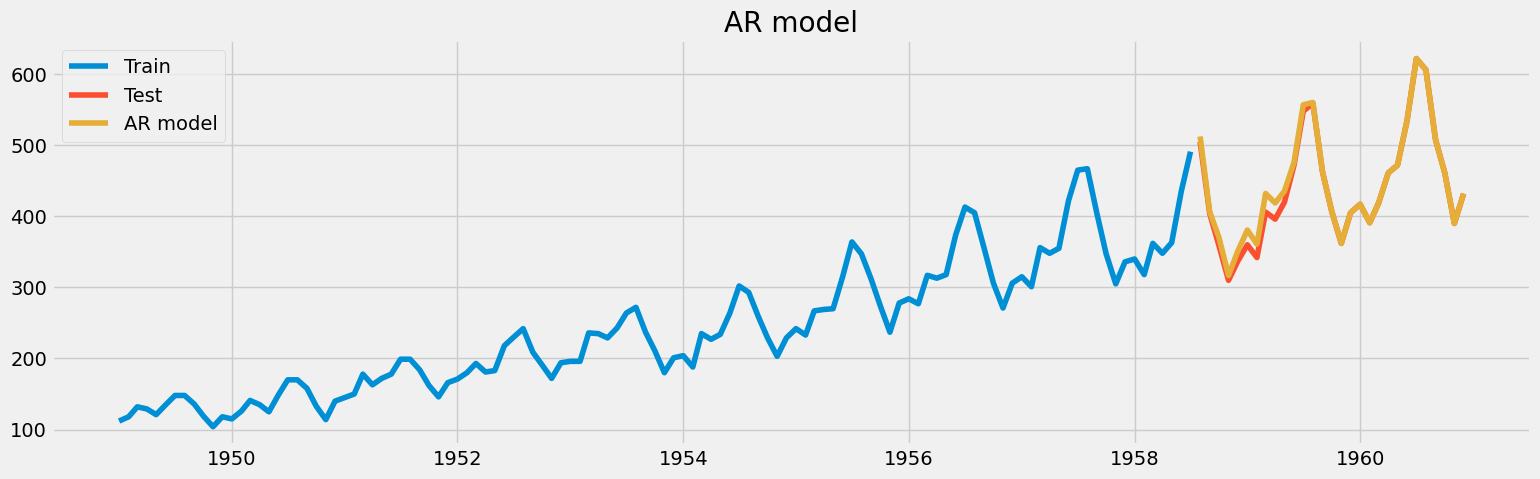

In [36]:
plt.plot(train['#Passengers'], label = 'Train')
plt.plot(test['#Passengers'], label = 'Test')
plt.plot(predictions_AR[test.index.min():], label = 'AR model')

plt.legend()
plt.title('AR model')
plt.show()

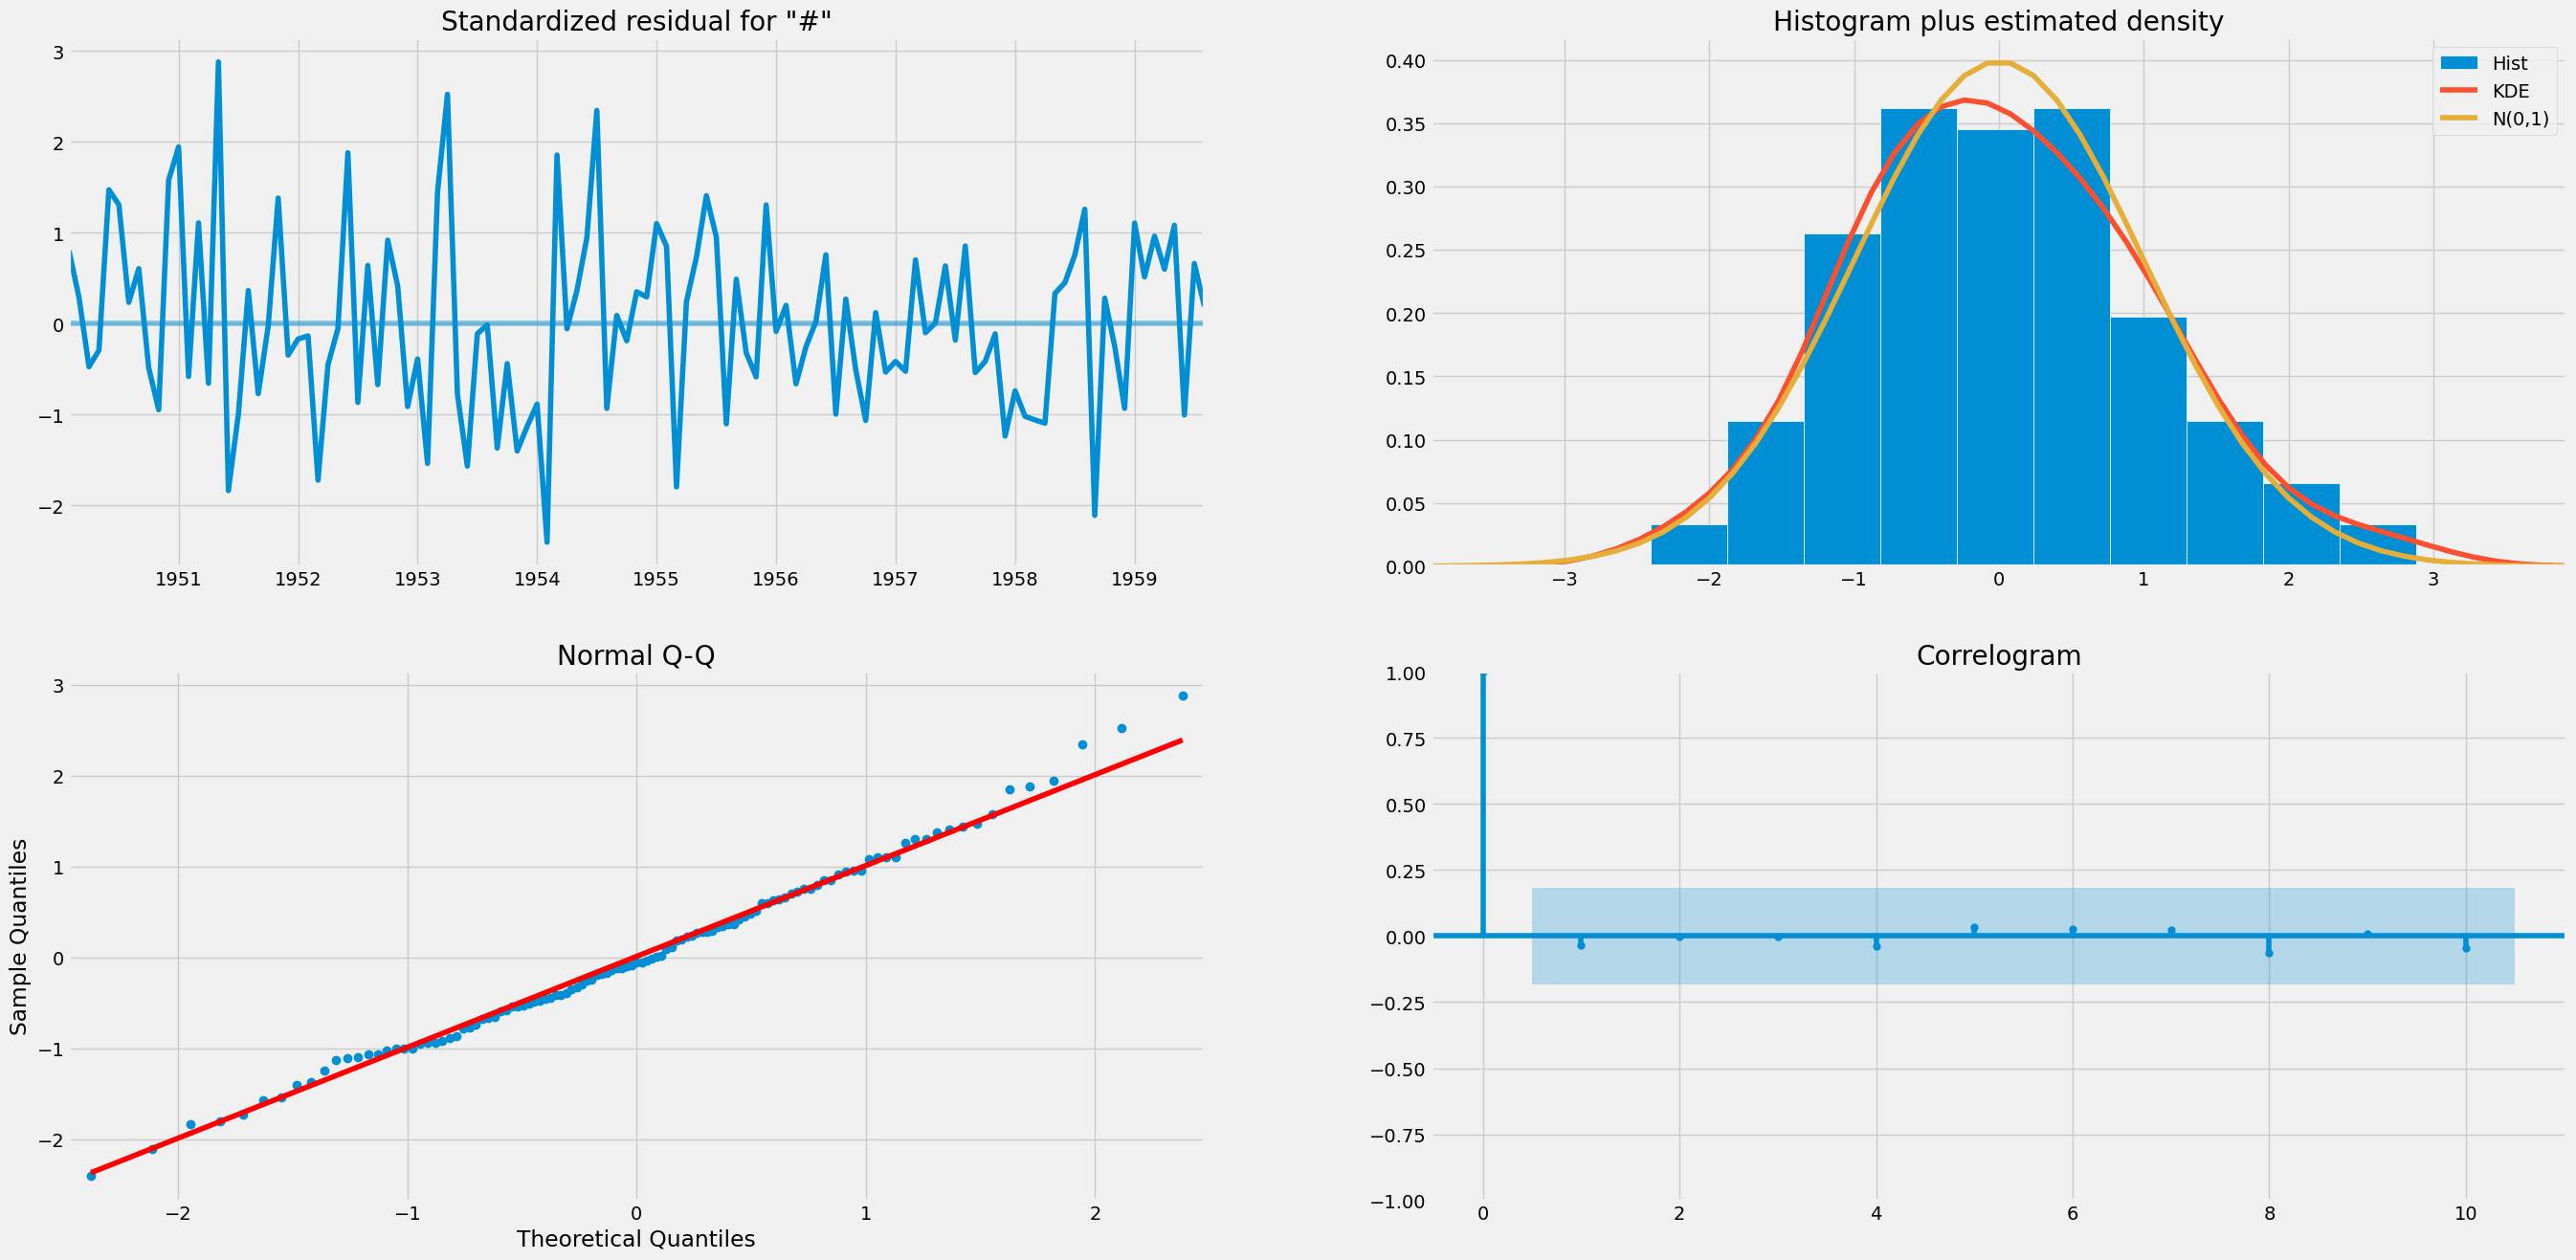

In [37]:
x = model_fit_ar.plot_diagnostics(figsize=(30,15))

MA

In [38]:
model_ma = ARIMA(train_boxcox_second_order_diff, order=(0,0,12))
model_fit_ma = model_ma.fit()
model_fit_ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  115
Model:                ARIMA(0, 0, 12)   Log Likelihood                 126.482
Date:                Tue, 02 Apr 2024   AIC                           -224.964
Time:                        18:25:08   BIC                           -186.535
Sample:                    02-01-1950   HQIC                          -209.366
                         - 08-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.002     -0.180      0.857      -0.004       0.003
ma.L1         -0.3108      0.151     -2.054      0.040      -0.607      -0.014
ma.L2          0.0912      0.146      0.625      0.532      -0.195       0.377
ma.L3         -0.2190      0.161     -1.362      0.173      -0.534       0.096
ma.L4         -0.2046      0.155     -1.320      0.187      -0.508       0.099
ma.L5          0.1024      0.102      1.000      0.317      -0.098       0.303
ma.L6         -0.0508      0.171     -0.297      0.766      -0.386       0.284
ma.L7          0.1366      0.139      0.981      0.327      -0.136       0.409
ma.L8         -0.0327      0.131     -0.250      0.803      -0.289       0.224
ma.L9          0.1362      0.138      0.989      0.322      -0.134       0.406
ma.L10        -0.0146      0.141     -0.103      0.918      -0.292       0.263
ma.L11         0.0564      0.147      0.384      0.701      -0.232       0.344
ma.L12        -0.6037      0.146     -4.146      0.000      -0.889      -0.318
sigma2         0.0062      0.001      7.021      0.000       0.004       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 2.57
Prob(Q):                              0.76   Prob(JB):                         0.28
Heteroskedasticity (H):               0.41   Skew:                            -0.02
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
pred_MA_diff = pd.Series(model_fit_ma.fittedvalues, copy=True)
pred_MA_diff_cumsum = pred_MA_diff.cumsum()

pred_MA_boxcox = pd.Series(data_boxcox, index=data_boxcox.index)
pred_MA_boxcox = pred_MA_boxcox.add(pred_MA_diff_cumsum, fill_value=0)

pred_MA = inv_boxcox(pred_MA_boxcox, fitted_lambda)

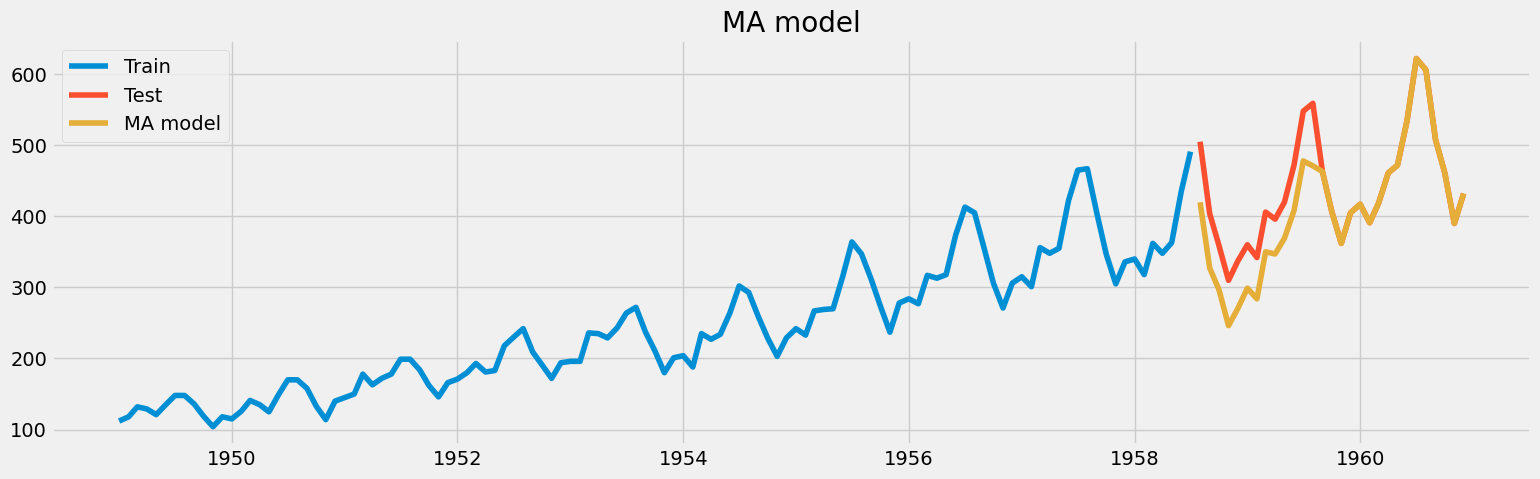

In [40]:
plt.plot(train['#Passengers'], label = 'Train')
plt.plot(test['#Passengers'], label = 'Test')
plt.plot(pred_MA[test.index.min():], label = 'MA model')

plt.legend()
plt.title('MA model')
plt.show()

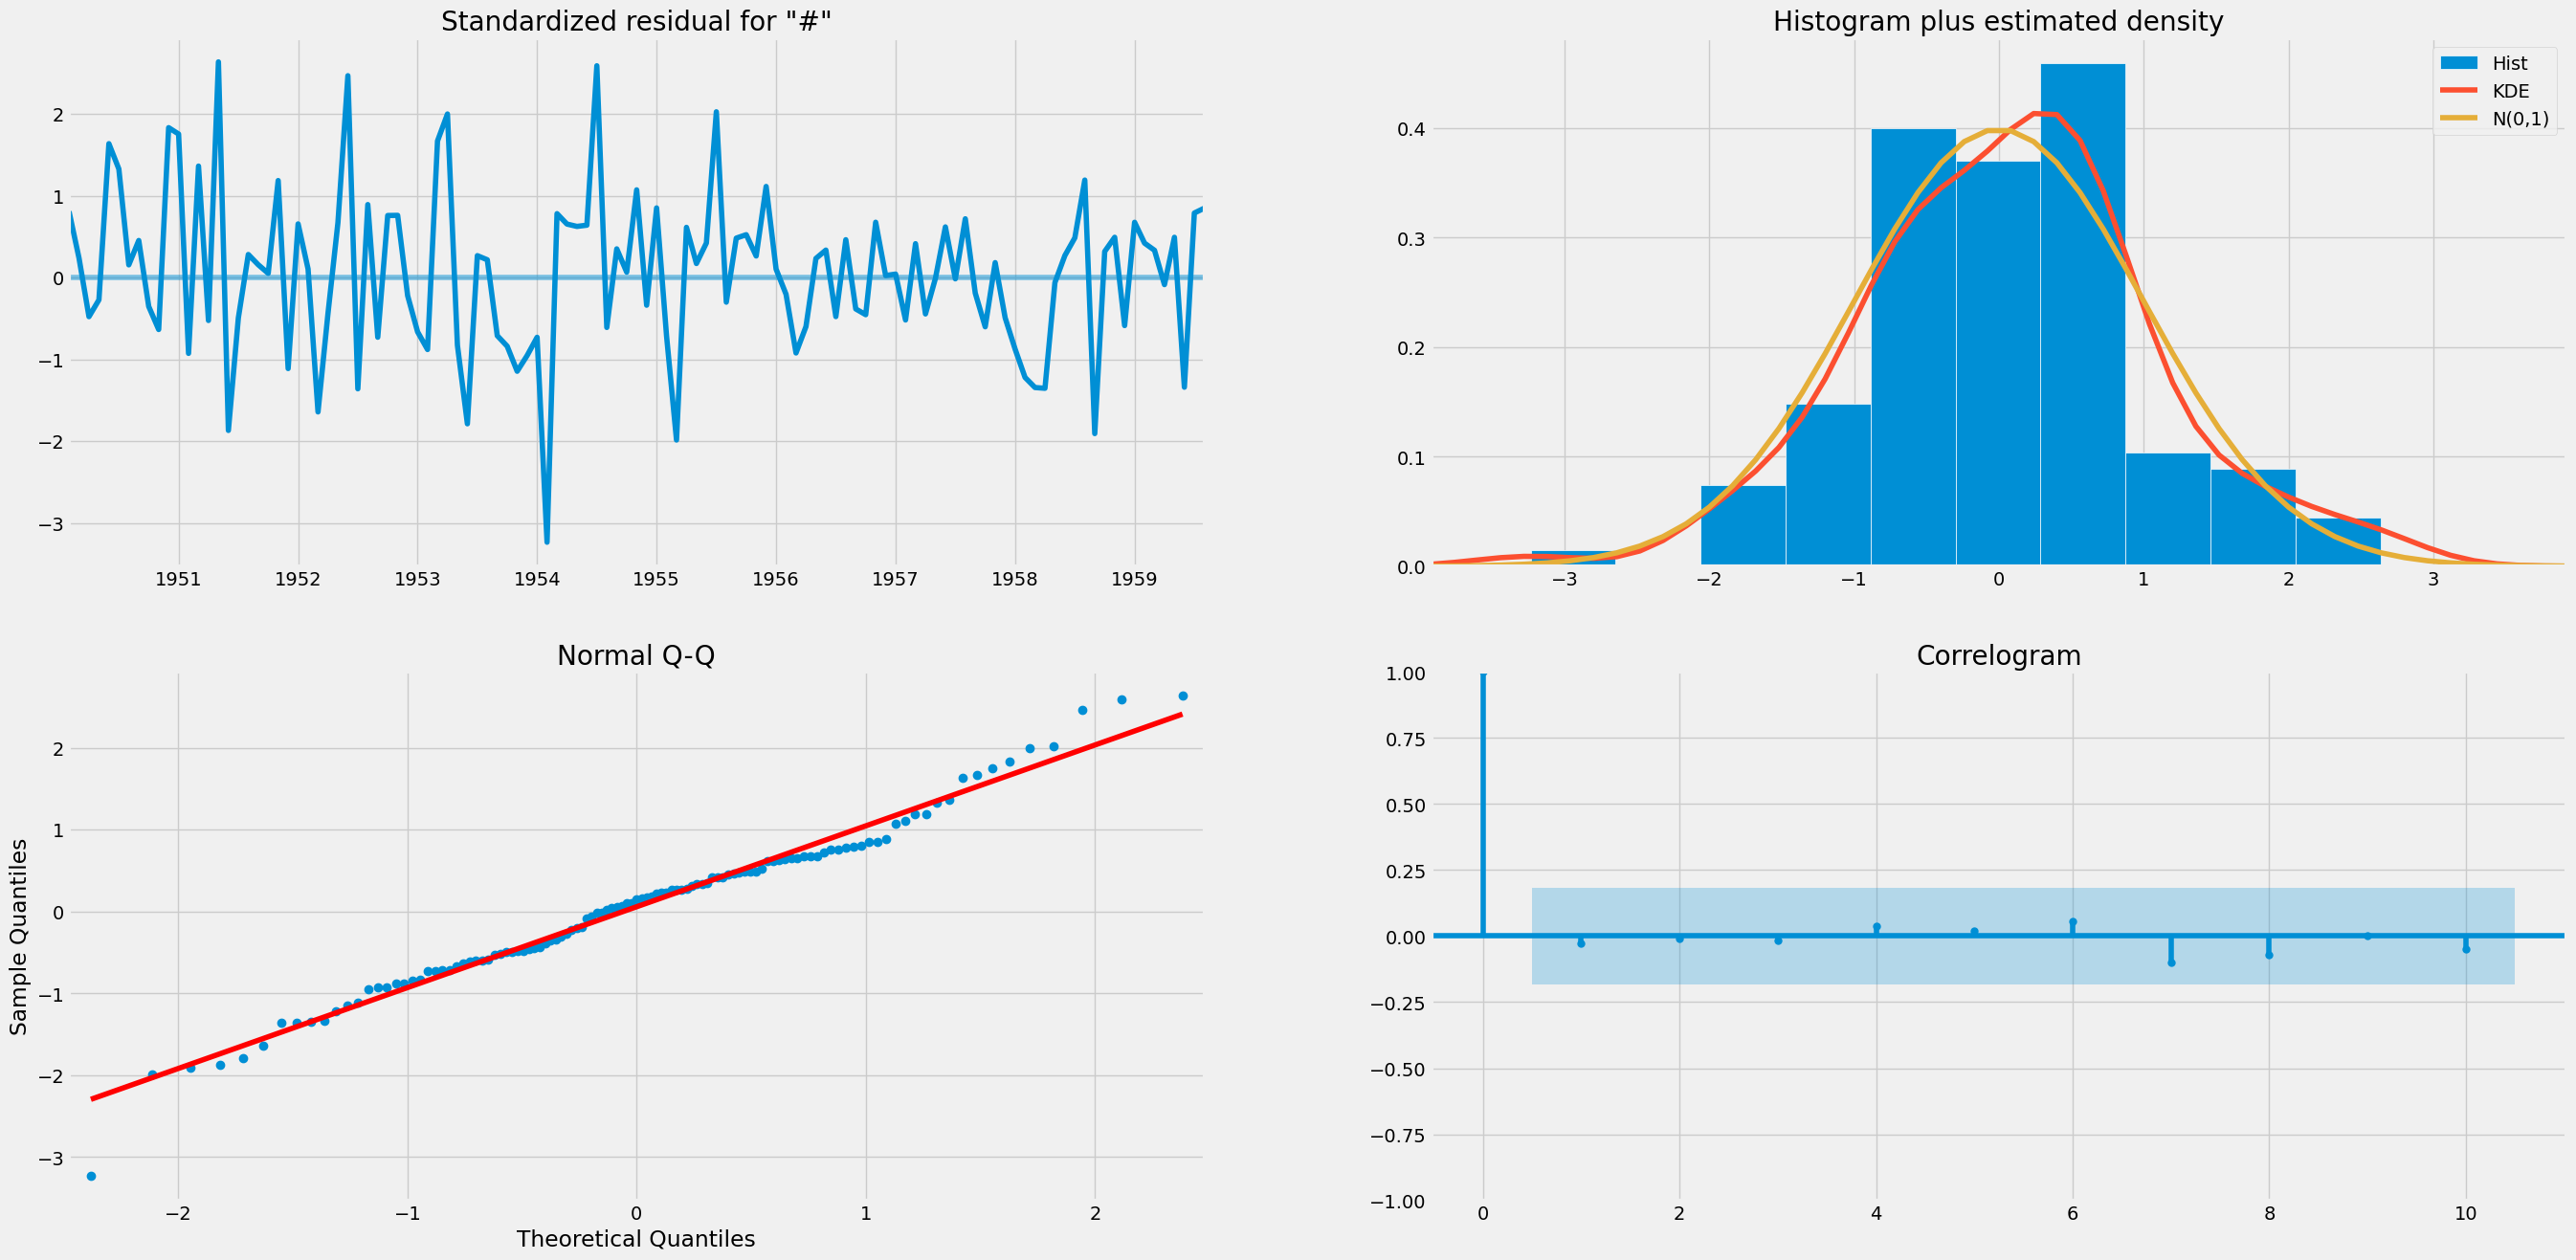

In [41]:
x = model_fit_ma.plot_diagnostics(figsize=(30,15))

ARMA

In [42]:
model_arma = ARIMA(train_boxcox_second_order_diff, order=(6,0,6))
model_fit_arma = model_arma.fit()
model_fit_arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  115
Model:                 ARIMA(6, 0, 6)   Log Likelihood                 121.119
Date:                Tue, 02 Apr 2024   AIC                           -214.239
Time:                        18:26:19   BIC                           -175.810
Sample:                    02-01-1950   HQIC                          -198.641
                         - 08-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.007      0.219      0.826      -0.013       0.016
ar.L1         -0.0627      0.348     -0.180      0.857      -0.744       0.619
ar.L2          0.2007      0.249      0.807      0.420      -0.287       0.688
ar.L3         -0.5896      0.218     -2.709      0.007      -1.016      -0.163
ar.L4          0.3541      0.198      1.786      0.074      -0.035       0.743
ar.L5          0.0173      0.275      0.063      0.950      -0.521       0.556
ar.L6         -0.5110      0.173     -2.954      0.003      -0.850      -0.172
ma.L1         -0.1775      0.352     -0.505      0.614      -0.867       0.511
ma.L2         -0.1072      0.316     -0.339      0.735      -0.727       0.512
ma.L3          0.4420      0.161      2.745      0.006       0.126       0.757
ma.L4         -0.6454      0.295     -2.189      0.029      -1.223      -0.068
ma.L5          0.3676      0.315      1.167      0.243      -0.250       0.985
ma.L6          0.4749      0.273      1.737      0.082      -0.061       1.011
sigma2         0.0068      0.002      3.934      0.000       0.003       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 0.63
Prob(Q):                              0.66   Prob(JB):                         0.73
Heteroskedasticity (H):               0.46   Skew:                             0.16
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
pred_ARMA_diff = pd.Series(model_fit_arma.fittedvalues, copy=True)
pred_ARMA_diff_cumsum = pred_ARMA_diff.cumsum()

pred_ARMA_boxcox = pd.Series(data_boxcox, index=data_boxcox.index)
pred_ARMA_boxcox = pred_ARMA_boxcox.add(pred_ARMA_diff_cumsum, fill_value=0)

pred_ARMA = inv_boxcox(pred_ARMA_boxcox, fitted_lambda)

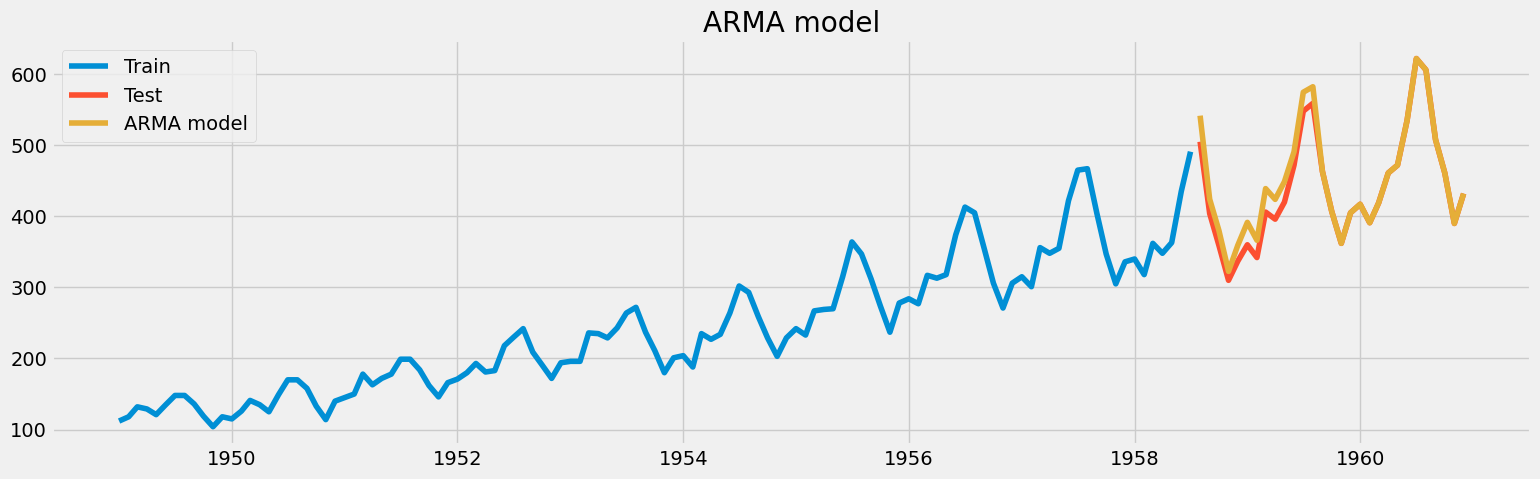

In [44]:
plt.plot(train['#Passengers'], label = 'Train')
plt.plot(test['#Passengers'], label = 'Test')
plt.plot(pred_ARMA[test.index.min():], label = 'ARMA model')

plt.legend()
plt.title('ARMA model')
plt.show()

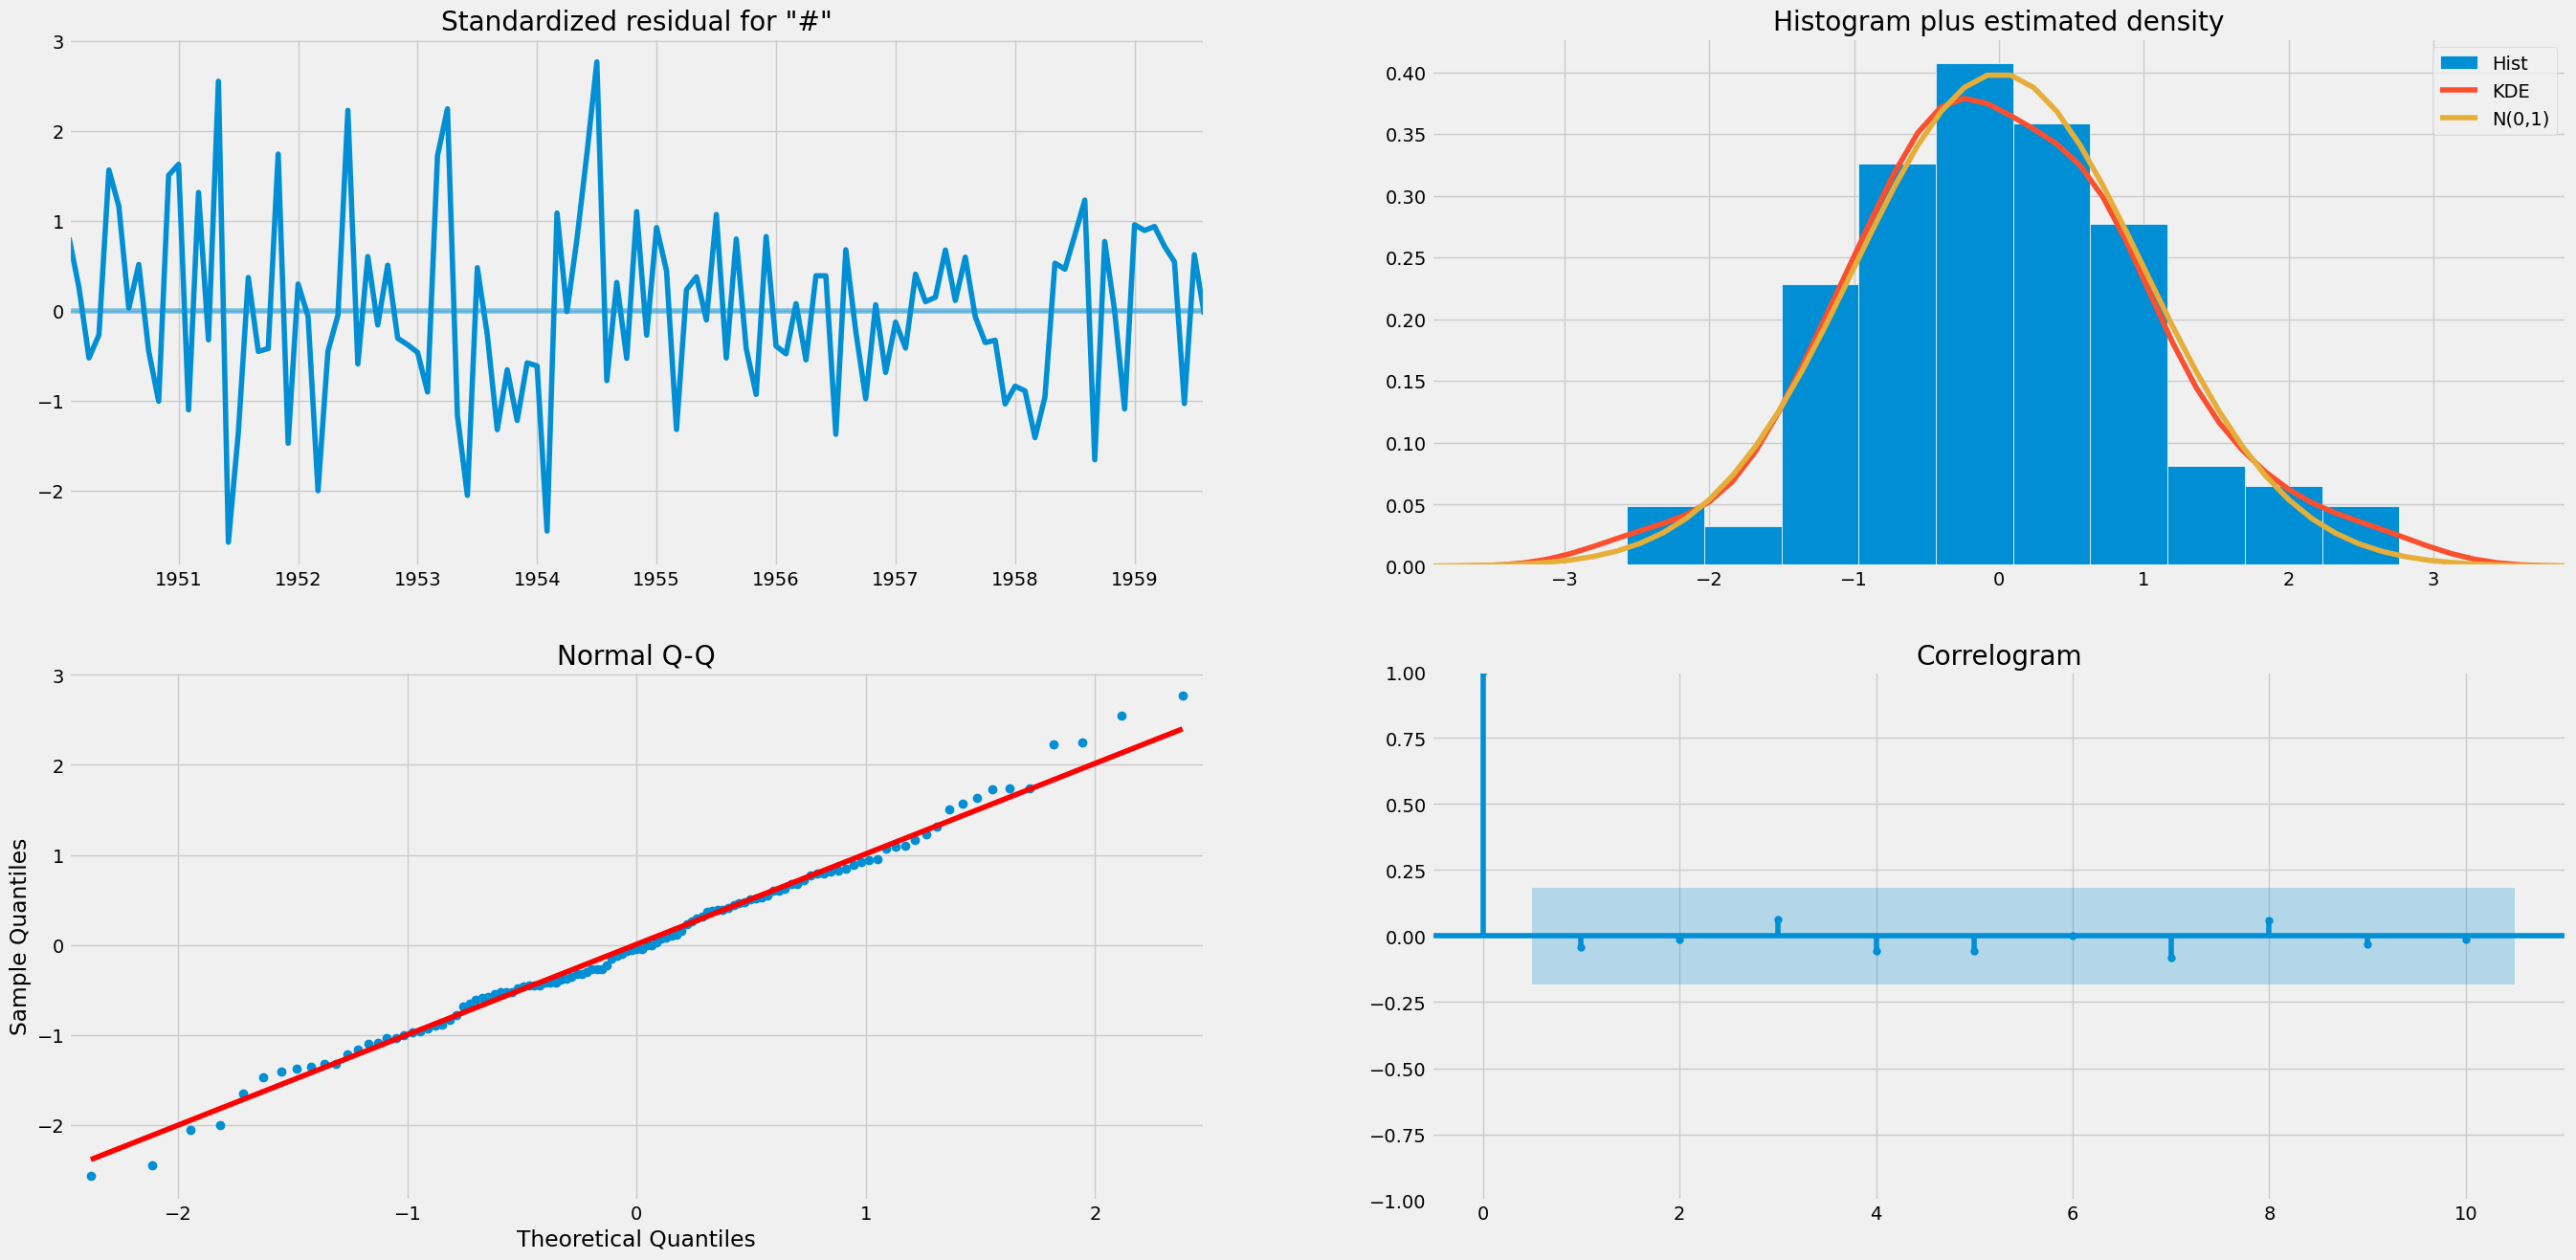

In [45]:
x = model_fit_arma.plot_diagnostics(figsize=(30,15))

ARIMA

In [46]:
model_arima = ARIMA(train_boxcox_second_order_diff, order=(6,1,6))
model_fit_arima = model_arima.fit()
model_fit_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  115
Model:                 ARIMA(6, 1, 6)   Log Likelihood                 116.580
Date:                Tue, 02 Apr 2024   AIC                           -207.161
Time:                        18:27:43   BIC                           -171.590
Sample:                    02-01-1950   HQIC                          -192.725
                         - 08-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9125      0.621     -3.081      0.002      -3.129      -0.696
ar.L2         -2.2332      1.234     -1.809      0.070      -4.653       0.186
ar.L3         -2.3637      1.226     -1.928      0.054      -4.767       0.039
ar.L4         -1.7030      1.217     -1.399      0.162      -4.088       0.682
ar.L5         -0.8317      0.900     -0.924      0.355      -2.595       0.932
ar.L6         -0.2676      0.251     -1.064      0.287      -0.760       0.225
ma.L1          0.6723     30.123      0.022      0.982     -58.368      59.712
ma.L2          0.2454     50.543      0.005      0.996     -98.817      99.308
ma.L3          0.0427     58.025      0.001      0.999    -113.683     113.769
ma.L4         -0.9414     59.391     -0.016      0.987    -117.346     115.463
ma.L5         -0.7204     31.039     -0.023      0.981     -61.556      60.115
ma.L6         -0.2983      9.165     -0.033      0.974     -18.262      17.665
sigma2         0.0069      0.209      0.033      0.974      -0.403       0.417
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.83   Prob(JB):                         0.54
Heteroskedasticity (H):               0.41   Skew:                            -0.02
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
pred_ARIMA_diff = pd.Series(model_fit_arima.fittedvalues, copy=True)
pred_ARIMA_diff_cumsum = pred_ARIMA_diff.cumsum()

pred_ARIMA_boxcox = pd.Series(data_boxcox, index=data_boxcox.index)
pred_ARIMA_boxcox = pred_ARIMA_boxcox.add(pred_ARIMA_diff_cumsum, fill_value=0)

pred_ARIMA = inv_boxcox(pred_ARIMA_boxcox, fitted_lambda)

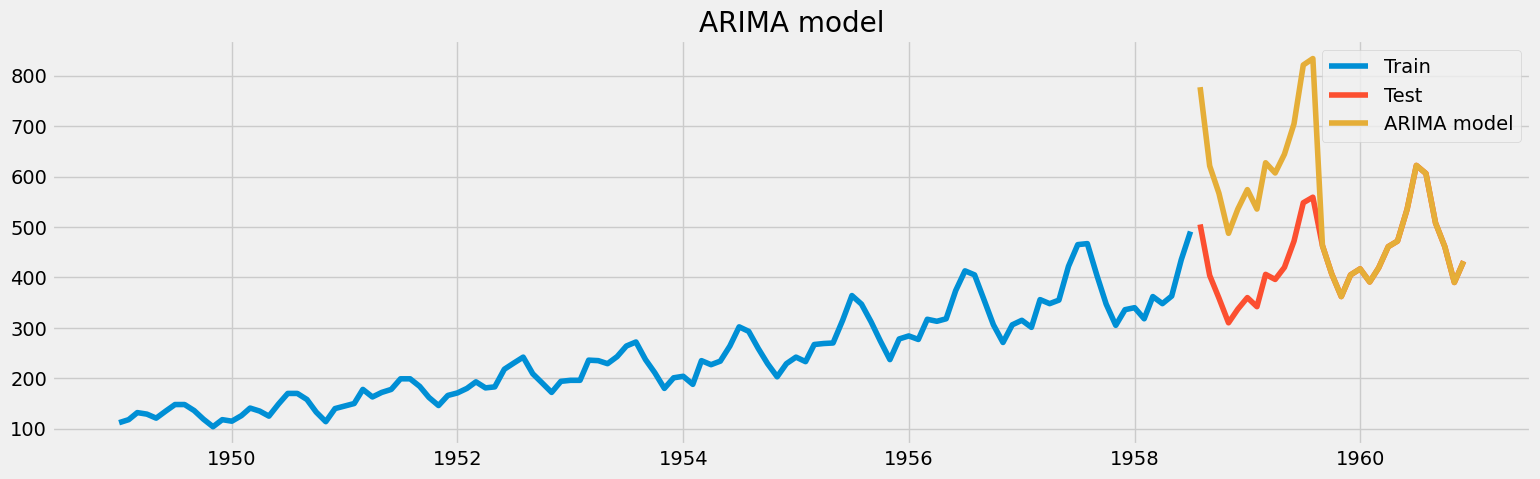

In [48]:
plt.plot(train['#Passengers'], label = 'Train')
plt.plot(test['#Passengers'], label = 'Test')
plt.plot(pred_ARIMA[test.index.min():], label = 'ARIMA model')

plt.legend()
plt.title('ARIMA model')
plt.show()

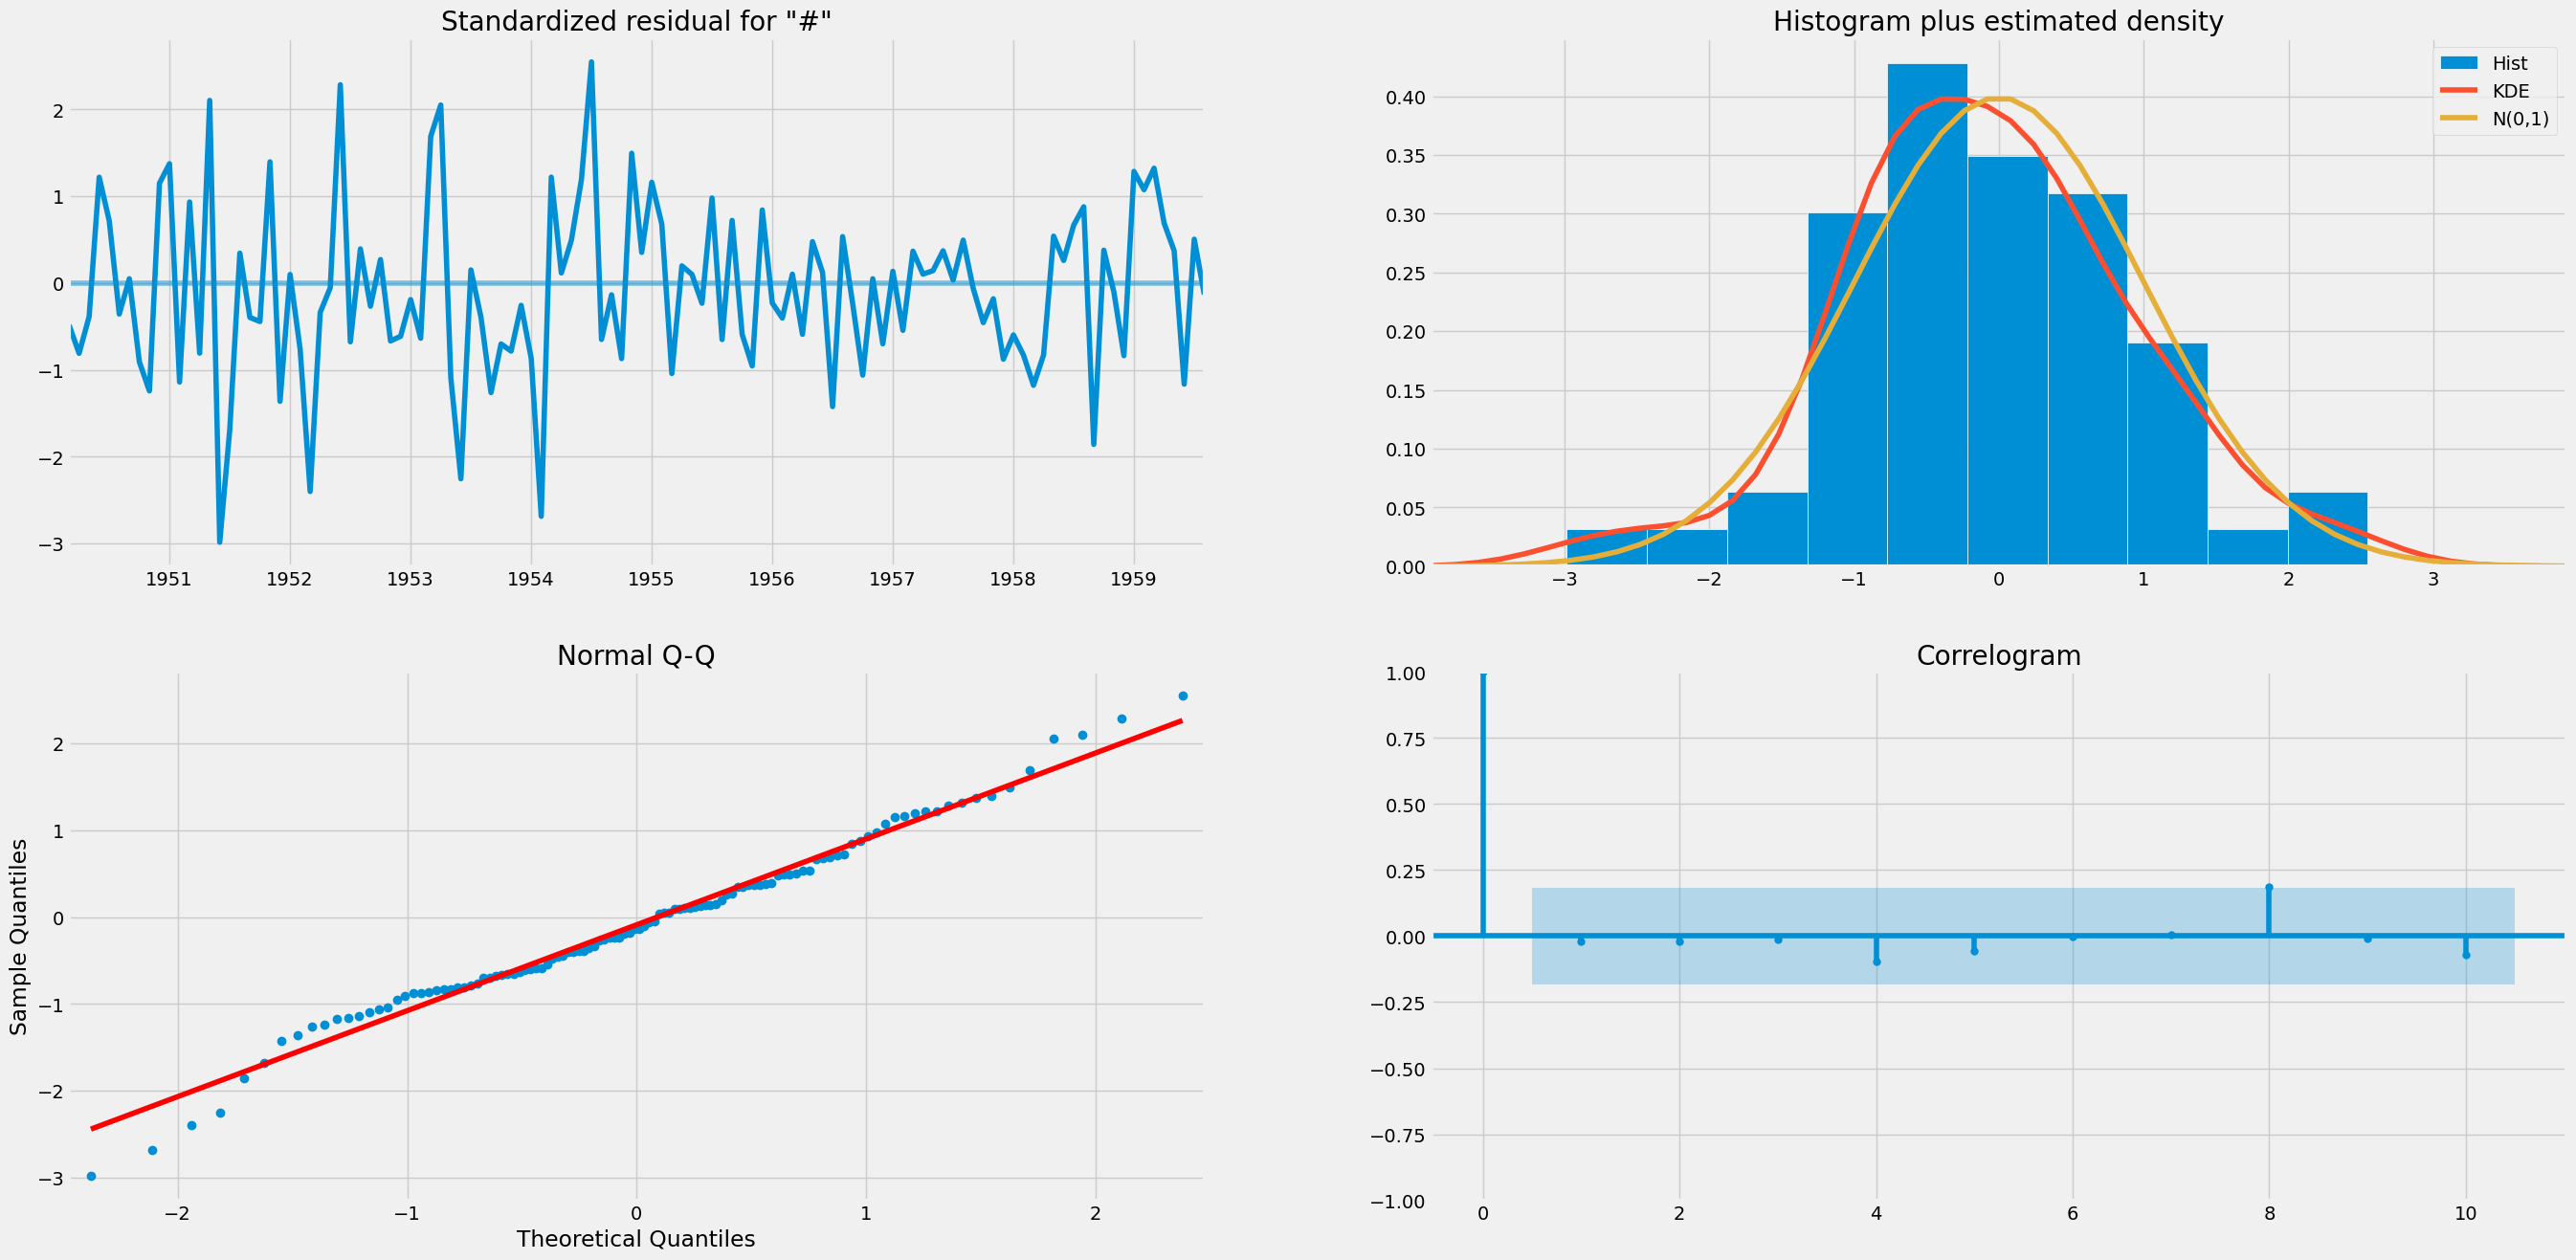

In [49]:
x = model_fit_arima.plot_diagnostics(figsize=(30,15))